In [1]:
import mne
import signal_metrics
from pathlib import Path
import bids
import pickle
from eeg_fmri_cleaning import GradientRemover
import numpy as np
import os
import eeg_fmri_cleaning.main as cleaner

In [2]:
%%capture
def mne_metrics(filename, saving_pathname, folder = None):
    filename_entities = bids.layout.parse_file_entities(filename.name)

    if os.path.splitext(filename)[1] == '.set':
        raw = mne.io.read_raw_eeglab(filename, preload=True)
        channel_map = cleaner.map_channel_type(raw)
        raw = cleaner.set_channel_types(raw, channel_map)
    elif os.path.splitext(filename)[1] == '.fif':
        raw = mne.io.read_raw_fif(filename, preload=True)
        
    if filename_entities['task'] == 'checker':
        trigger_name = GradientRemover.extract_gradient_trigger_name(raw)
        annotations = raw.annotations
        index_grad_trigger = np.where(annotations.description == trigger_name)
        third_grad_trigger = annotations.onset[index_grad_trigger[0][1]]
        last_grad_trigger = annotations.onset[index_grad_trigger[0][-1]]
        
        raw.crop(tmin=third_grad_trigger, tmax=last_grad_trigger)
    
    raw_time_metrics = signal_metrics.SignalMetrics(raw)
    raw_time_metrics.calculate_time_metrics()

    noise_freq_tagging = signal_metrics.SignalMetrics(raw)
    noise_freq_tagging.calculate_frequency_metrics(frequency_range=(17,20),
                                                                frequency_type="noise")
    ssvep_freq_tagging = signal_metrics.SignalMetrics(raw)
    ssvep_freq_tagging.calculate_frequency_metrics(frequency_range=(11,13),
                                                                frequency_type="signal")
    try:
        ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
        epochs_ecg_metrics = signal_metrics.SignalMetrics(ecg_epochs)
        epochs_ecg_metrics.calculate_time_metrics()
    except:
        pass
        
    filename_path = Path(filename)
    base_filename =  os.path.splitext(filename_path)[0]
    for metric_object, metric_object_name in zip([raw_time_metrics, 
                                                noise_freq_tagging, 
                                                ssvep_freq_tagging, 
                                                epochs_ecg_metrics], 
                                                ['raw_time_metrics', 
                                                'noise_freq_tagging', 
                                                'ssvep_freq_tagging',
                                                'epochs_ecg_metrics'] 
                                                ):

        saving_filename = "_".join([os.path.splitext(filename_path.name)[0],
                                    #folder,
                                metric_object_name + '.pkl'])
        saving_full_filename = "/".join([saving_pathname,saving_filename])
        with open(saving_full_filename, 'wb') as f:
            pickle.dump(metric_object, f)
        print(f'{saving_full_filename} saved')

# CBIN-method metrics

In [3]:
%%capture
path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES')
folders = ['GRAD_BCG',
         'GRAD_BCG_ASR']
errors = {}
for folder in folders:
    child_path = path / folder
    for child_child_path in child_path.iterdir():
        for child_child_child_path in child_child_path.iterdir():
            eeg_path = child_child_child_path / 'eeg'
            for file in eeg_path.iterdir():
                if os.path.splitext(file)[1] == '.fif':
                    mne_metrics(file, path/'metrics', folder = folder)

# Brainvision metrics

In [4]:
%%capture
path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_EEGLAB_2024/')
errors = {}
for file in path.iterdir():
    if os.path.splitext(file)[1] == '.set':
        filename_entities = bids.layout.parse_file_entities(file.name)
        if 'checker' in filename_entities['task']:
            try:
                mne_metrics(file)
            except Exception as e:
                errors[file] = e
                print(f'Error in {file}: {e}')
                continue

# EEGLAB metrics

In [3]:
%%capture
path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_EEGLAB_2024')
saving_pathname = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method')
errors = {}
for child_child_path in path.iterdir():
    for child_child_child_path in child_child_path.iterdir():
        eeg_path = child_child_child_path / 'eeg'
        for file in eeg_path.iterdir():
            if os.path.splitext(file)[1] == '.set':
                try:
                    print(file)
                    mne_metrics(file, str(saving_pathname))
                except Exception as e:
                    errors[file] = e
                    print(f'Error in {file}: {e}')
                    continue

NotADirectoryError: [Errno 20] Not a directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_EEGLAB_2024/participants.tsv'

# Outside scanner metrics

In [3]:
%%capture
errors = {}
reading_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/RAW')
saving_pathname = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_raw')
layout = bids.layout.BIDSLayout(reading_path)
file_list = layout.get(extension = '.set', task = 'checkerout')
for file in file_list:
    try:
        mne_metrics(Path(file), str(saving_pathname))
    except Exception as e:
        errors[file] = e
        print(f'Error in {file}: {e}')
        continue

In [3]:
with open('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_cbin_method/sub-11_ses-01_task-checker_run-01_eeg_GRAD_BCG_ASR_epochs_ecg_metrics.pkl', 'rb') as f:
    obj = pickle.load(f)

# Errors while reading eeglab files

In [10]:
s = 'sub-01_ses-01_task-checkerout_run-01_eeg_epochs_ecg_metrics.pkl'
entities = bids.layout.parse_file_entities(s)

/home/slouviot/miniconda3/envs/mne/lib/python3.12/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [11]:
entities

{'session': '01',
 'task': 'checkerout',
 'run': 1,
 'suffix': 'metrics',
 'extension': 'pkl'}

# Time domain metrics

In [37]:
path_brainvision = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_bv_method')
path_sam = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_cbin_method')
path_sam_asr = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_cbin_method')
eeglab_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method')
outside_scanner = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_raw')


metrics = [
    'average_rms',
    'max_gradient',
    'zero_crossing_rate',
    'hjorth_mobility',
    'hjorth_complexity',
    'kurtosis',
    'skewness',
    'variance',
    'signal_range',
    'signal_iqr',
    'snr_epochs'
    ]

brainvision_metrics_dict = {
    metric: list() for metric in metrics
}

eeglab_metrics_dict = {
    metric: list() for metric in metrics
}

sam_metrics_dict = {
    metric: list() for metric in metrics
}

sam_asr_metrics_dict = {
    metric: list() for metric in metrics
}

raw_metrics_dict = {
    metric: list() for metric in metrics
}

error_log = dict()
subject_treated = list()

metric_type = 'epochs_ecg_metrics'

for file in outside_scanner.iterdir():
    if metric_type not in file.name:
        continue
    
    entities = bids.layout.parse_file_entities(file.name)
    file_string = file.name
    base_file = file_string[:file_string.find('eeg')+3]
    file_sam = base_file + f'_GRAD_BCG_{metric_type}.pkl'
    file_sam_asr = base_file + f'_GRAD_BCG_ASR_{metric_type}.pkl'

    full_file_sam = path_sam / file_sam
    full_file_sam_asr = path_sam / file_sam_asr
    full_file_eeglab = eeglab_path / file.name
    full_file_brainvision = path_brainvision / file.name

    try:
        subject = file.name[:6]
        subject_treated.append(subject)

        #brain vision metrics
        process = 'brain_vision'
        file_process = file
        with open(full_file_brainvision, 'rb') as f:
            brainvision_metrics = pickle.load(f)
            for metric in metrics:
                brainvision_metrics_dict[metric].append(getattr(brainvision_metrics,metric).flatten())
        
        #eeglab metrics
        process = 'eeglab'
        file_process = full_file_eeglab
        #with open(full_file_eeglab, 'rb') as f:
        #    eeglab_metrics = pickle.load(f)
        #    for metric in metrics:
        #        if metric != 'snr_epochs':
        #            eeglab_metrics_dict[metric].append(getattr(eeglab_metrics,metric).flatten())
        
        #cbin-metrics
        process = 'sam'
        file_process = full_file_sam
        #sam metrics
        with open(full_file_sam, 'rb') as f:
            sam_metrics = pickle.load(f)
            for metric in metrics:
                sam_metrics_dict[metric].append(getattr(sam_metrics,metric).flatten())

        #cbin asr metrics
        process = 'sam_asr'
        file_process = full_file_sam_asr
        with open(full_file_sam_asr, 'rb') as f:
            sam_asr_metrics = pickle.load(f)
            for metric in metrics:
                sam_asr_metrics_dict[metric].append(getattr(sam_asr_metrics,metric).flatten())
        
        #raw metrics
        process = 'raw'
        file_process = file
        with open(str(file), 'rb') as f:
            raw_metrics = pickle.load(f)
            for metric in metrics:
                raw_metrics_dict[metric].append(getattr(raw_metrics,metric).flatten())
        
        
        process = 'done'
    except Exception as e:
        error_log[subject] = f"{e} in {process} with file {file_process}"

for metric in metrics:
    brainvision_metrics_dict[metric] = np.concatenate(brainvision_metrics_dict[metric])
    sam_metrics_dict[metric] = np.concatenate(sam_metrics_dict[metric])
    sam_asr_metrics_dict[metric] = np.concatenate(sam_asr_metrics_dict[metric])
    raw_metrics_dict[metric] = np.concatenate(raw_metrics_dict[metric])
    try:
        eeglab_metrics_dict[metric] = np.concatenate(eeglab_metrics_dict[metric])
    except:
        continue
    

/home/slouviot/miniconda3/envs/mne/lib/python3.12/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [15]:
error_log

{'sub-12': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method/sub-12_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl' in eeglab with file sub-12_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl",
 'sub-08': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method/sub-08_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl' in eeglab with file sub-08_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl",
 'sub-02': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method/sub-02_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl' in eeglab with file sub-02_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl",
 'sub-20': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method/sub-20_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl' in eeglab with file

In [41]:
import seaborn
import matplotlib.pyplot as plt
def plot_time_metrics(brainvision_metrics_dict,
                      sam_metrics_dict,
                      sam_asr_metrics_dict,):
                      #eeglab_metrics_dict):#,
                      #raw_metrics_dict):
    metrics = [
        'average_rms',
        'max_gradient',
        'hjorth_mobility',
        'hjorth_complexity',
        'kurtosis',
        'skewness',
        'variance',
        'signal_range',
        'signal_iqr',
        'snr_epochs'
        ]

    xlimits = {
    'average_rms': (0,0.0001),
    'max_gradient': (0,0.001),
    'hjorth_mobility': (0,2),
    'hjorth_complexity': (1,3.5),
    'kurtosis': (-3,25),
    'skewness': (-4,4),
    'variance': (0,1e-8),
    'signal_range': (0,0.0015),
    'signal_iqr': (0,0.0001),
    'snr_epochs': (-50,50)
    }



    fig, ax1 = plt.subplots(figsize = (20,10))
    ax1.spines[['right','left', 'top', 'bottom']].set_visible(False)
    ax1.set_yticks([])

    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(2, 5, 1 + i)
        if i == 0:
            legend = True
        else:
            legend = False
        seaborn.kdeplot(data={'brainvision':brainvision_metrics_dict[metric],
                            'cbin':sam_metrics_dict[metric],
                            'cbin+asr':sam_asr_metrics_dict[metric],
                            #'eeeglab':eeglab_metrics_dict[metric]},
                            #'outside_scanner':raw_metrics_dict[metric],
                            },
                        x=None, 
                        y=None, 
                        hue=None, 
                        weights=None, 
                        palette=None, 
                        hue_order=None, 
                        hue_norm=None, 
                        color=None, 
                        fill=True, 
                        multiple='layer', 
                        common_norm=True, 
                        common_grid=False, 
                        cumulative=False, 
                        bw_method='scott', 
                        bw_adjust=1, 
                        warn_singular=True, 
                        log_scale=None, 
                        levels=10, 
                        thresh=0.05, 
                        gridsize=200, 
                        cut=3, 
                        clip=None, 
                        legend=legend, 
                        cbar=False, 
                        cbar_ax=None, 
                        cbar_kws=None, 
                        ax=ax)
        ax.spines[['top','right']].set_visible(False)
        plt.title(metric)
        plt.xlim(xlimits[metric])

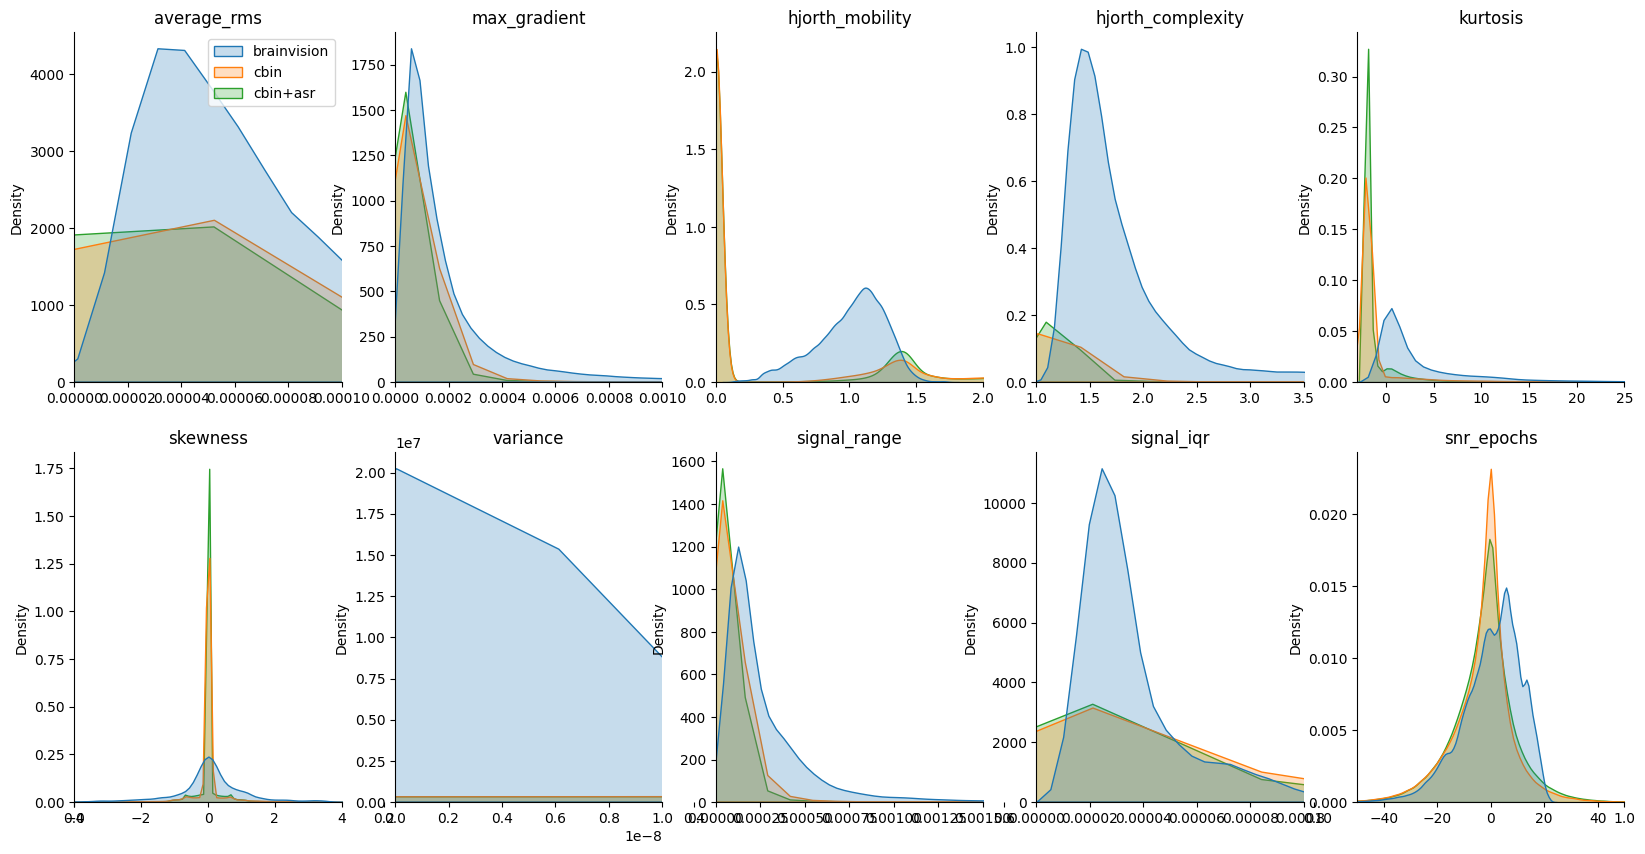

In [42]:
plot_time_metrics(
    brainvision_metrics_dict,
    sam_metrics_dict,
    sam_asr_metrics_dict,
    #eeglab_metrics_dict,
    #raw_metrics_dict
    )

# Frequency domain metrics

In [27]:
path_brainvision = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_2024/metrics_bv_method')
path_sam = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics')
path_sam_asr = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics')
metrics = [
    'amplitude_peak_magnitude',
    'zscore_peak_magnitude',
    'snr_peak_magnitude'
    ]
brainvision_metrics_dict = {
    metric: list() for metric in metrics
}

sam_metrics_dict = {
    metric: list() for metric in metrics
}

sam_asr_metrics_dict = {
    metric: list() for metric in metrics
}
error_log = dict()
subject_treated = list()

for file in path_brainvision.iterdir():
    subject = file.name[:6]
    file_sam = subject + '_ses-01_task-checker_run-01_eeg_GRAD_BCG_ssvep_freq_tagging.pkl'
    file_sam_asr = subject + '_ses-01_task-checker_run-01_eeg_GRAD_BCG_ASR_ssvep_freq_tagging.pkl'

    full_file_sam = path_sam / file_sam
    full_file_sam_asr = path_sam / file_sam_asr
    
    try:
        if 'ssvep_freq_tagging' in file.name:
            subject_treated.append(subject)
            #brain vision metrics
            with open(file, 'rb') as f:
                brainvision_metrics = pickle.load(f)
                for metric in metrics:
                    brainvision_metrics_dict[metric].append(getattr(brainvision_metrics,metric).flatten())

            #sam metrics
            with open(full_file_sam, 'rb') as f:
                sam_metrics = pickle.load(f)
                for metric in metrics:
                    sam_metrics_dict[metric].append(getattr(sam_metrics,metric).flatten())

            #sam asr metrics
            with open(full_file_sam_asr, 'rb') as f:
                sam_asr_metrics = pickle.load(f)
                for metric in metrics:
                    sam_asr_metrics_dict[metric].append(getattr(sam_asr_metrics,metric).flatten())
    except Exception as e:
        error_log[subject] = e

for metric in metrics:
    brainvision_metrics_dict[metric] = np.concatenate(brainvision_metrics_dict[metric])
    sam_metrics_dict[metric] = np.concatenate(sam_metrics_dict[metric])
    sam_asr_metrics_dict[metric] = np.concatenate(sam_asr_metrics_dict[metric])

In [48]:
path_brainvision = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_bv_method')
path_sam = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_cbin_method')
path_sam_asr = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_cbin_method')
eeglab_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method')
outside_scanner = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_raw')

metrics = [
    'amplitude_peak_magnitude',
    'zscore_peak_magnitude',
    'snr_peak_magnitude'
    ]

brainvision_metrics_dict = {
    metric: list() for metric in metrics
}

eeglab_metrics_dict = {
    metric: list() for metric in metrics
}

sam_metrics_dict = {
    metric: list() for metric in metrics
}

sam_asr_metrics_dict = {
    metric: list() for metric in metrics
}

raw_metrics_dict = {
    metric: list() for metric in metrics
}

error_log = dict()
subject_treated = list()

metric_type = 'noise_freq_tagging'

for file in outside_scanner.iterdir():
    if metric_type not in file.name:
        continue
    
    entities = bids.layout.parse_file_entities(file.name)
    file_string = file.name
    base_file = file_string[:file_string.find('eeg')+3]
    file_sam = base_file + f'_GRAD_BCG_{metric_type}.pkl'
    file_sam_asr = base_file + f'_GRAD_BCG_ASR_{metric_type}.pkl'

    full_file_sam = path_sam / file_sam
    full_file_sam_asr = path_sam / file_sam_asr
    full_file_eeglab = eeglab_path / file.name
    full_file_brainvision = path_brainvision / file.name

    try:
        subject = file.name[:6]
        subject_treated.append(subject)

        #brain vision metrics
        process = 'brain_vision'
        file_process = file
        with open(full_file_brainvision, 'rb') as f:
            brainvision_metrics = pickle.load(f)
            for metric in metrics:
                brainvision_metrics_dict[metric].append(getattr(brainvision_metrics,metric).flatten())
        
        #eeglab metrics
        process = 'eeglab'
        file_process = full_file_eeglab
        with open(full_file_eeglab, 'rb') as f:
            eeglab_metrics = pickle.load(f)
            for metric in metrics:
                if metric != 'snr_epochs':
                    eeglab_metrics_dict[metric].append(getattr(eeglab_metrics,metric).flatten())
        
        #cbin-metrics
        process = 'sam'
        file_process = full_file_sam
        #sam metrics
        with open(full_file_sam, 'rb') as f:
            sam_metrics = pickle.load(f)
            for metric in metrics:
                sam_metrics_dict[metric].append(getattr(sam_metrics,metric).flatten())

        #cbin asr metrics
        process = 'sam_asr'
        file_process = full_file_sam_asr
        with open(full_file_sam_asr, 'rb') as f:
            sam_asr_metrics = pickle.load(f)
            for metric in metrics:
                sam_asr_metrics_dict[metric].append(getattr(sam_asr_metrics,metric).flatten())
        
        #raw metrics
        #process = 'raw'
        #file_process = file
        #with open(str(file), 'rb') as f:
        #    raw_metrics = pickle.load(f)
        #    for metric in metrics:
        #        raw_metrics_dict[metric].append(getattr(raw_metrics,metric).flatten())
        
        
        process = 'done'
    except Exception as e:
        error_log[subject] = f"{e} in {process} with file {file_process}"

for metric in metrics:
    brainvision_metrics_dict[metric] = np.concatenate(brainvision_metrics_dict[metric])
    sam_metrics_dict[metric] = np.concatenate(sam_metrics_dict[metric])
    sam_asr_metrics_dict[metric] = np.concatenate(sam_asr_metrics_dict[metric])
    #raw_metrics_dict[metric] = np.concatenate(raw_metrics_dict[metric])
    try:
        eeglab_metrics_dict[metric] = np.concatenate(eeglab_metrics_dict[metric])
    except:
        continue
    

/home/slouviot/miniconda3/envs/mne/lib/python3.12/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [49]:
error_log

{'sub-20': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method/sub-20_ses-01_task-checker_run-01_eeg_noise_freq_tagging.pkl' in eeglab with file /projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method/sub-20_ses-01_task-checker_run-01_eeg_noise_freq_tagging.pkl",
 'sub-14': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_bv_method/sub-14_ses-02_task-checker_run-01_eeg_noise_freq_tagging.pkl' in brain_vision with file /projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_raw/sub-14_ses-02_task-checker_run-01_eeg_noise_freq_tagging.pkl",
 'sub-04': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_bv_method/sub-04_ses-02_task-checker_run-01_eeg_noise_freq_tagging.pkl' in brain_vision with file /projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_raw/sub-04_ses-02_task-checker_run-01_eeg_noise_freq_tagging.pkl",
 'sub

In [6]:
brainvision_metrics.amplitude_peak_magnitude

array([8.61324890e-07, 1.07030820e-06, 9.56946615e-07, 6.61865200e-07,
       7.72870374e-07, 6.60623888e-07, 7.17152206e-07, 1.03808358e-06,
       6.97332277e-07, 1.34938016e-06, 1.10882346e-06, 1.03815041e-06,
       1.33605068e-06, 1.12220395e-06, 1.56214238e-06, 1.44511606e-06,
       1.71446458e-06, 8.02867457e-07, 1.42035127e-06, 1.27682018e-06,
       1.22613877e-06, 1.72723665e-06, 6.87191774e-07, 1.27096319e-06,
       1.73175472e-06, 8.67069007e-07, 4.92177481e-07, 9.04891864e-07,
       6.76612726e-07, 9.71787231e-07, 1.14910959e-06, 4.48955249e-07,
       9.16469140e-07, 6.28604085e-07, 6.07790577e-07, 5.78342264e-07,
       6.94559146e-07, 1.22175637e-06, 1.27771209e-06, 6.68112136e-07,
       9.09370829e-07, 9.69968415e-07, 9.62053126e-07, 1.08837496e-06,
       1.12823899e-06, 1.83602787e-06, 1.03985841e-06, 7.69643432e-06,
       3.25237740e-06, 2.13949127e-06, 7.18267721e-07, 7.07918736e-07,
       1.34255882e-06, 6.36707772e-07, 7.71207714e-07, 1.32972643e-06,
      

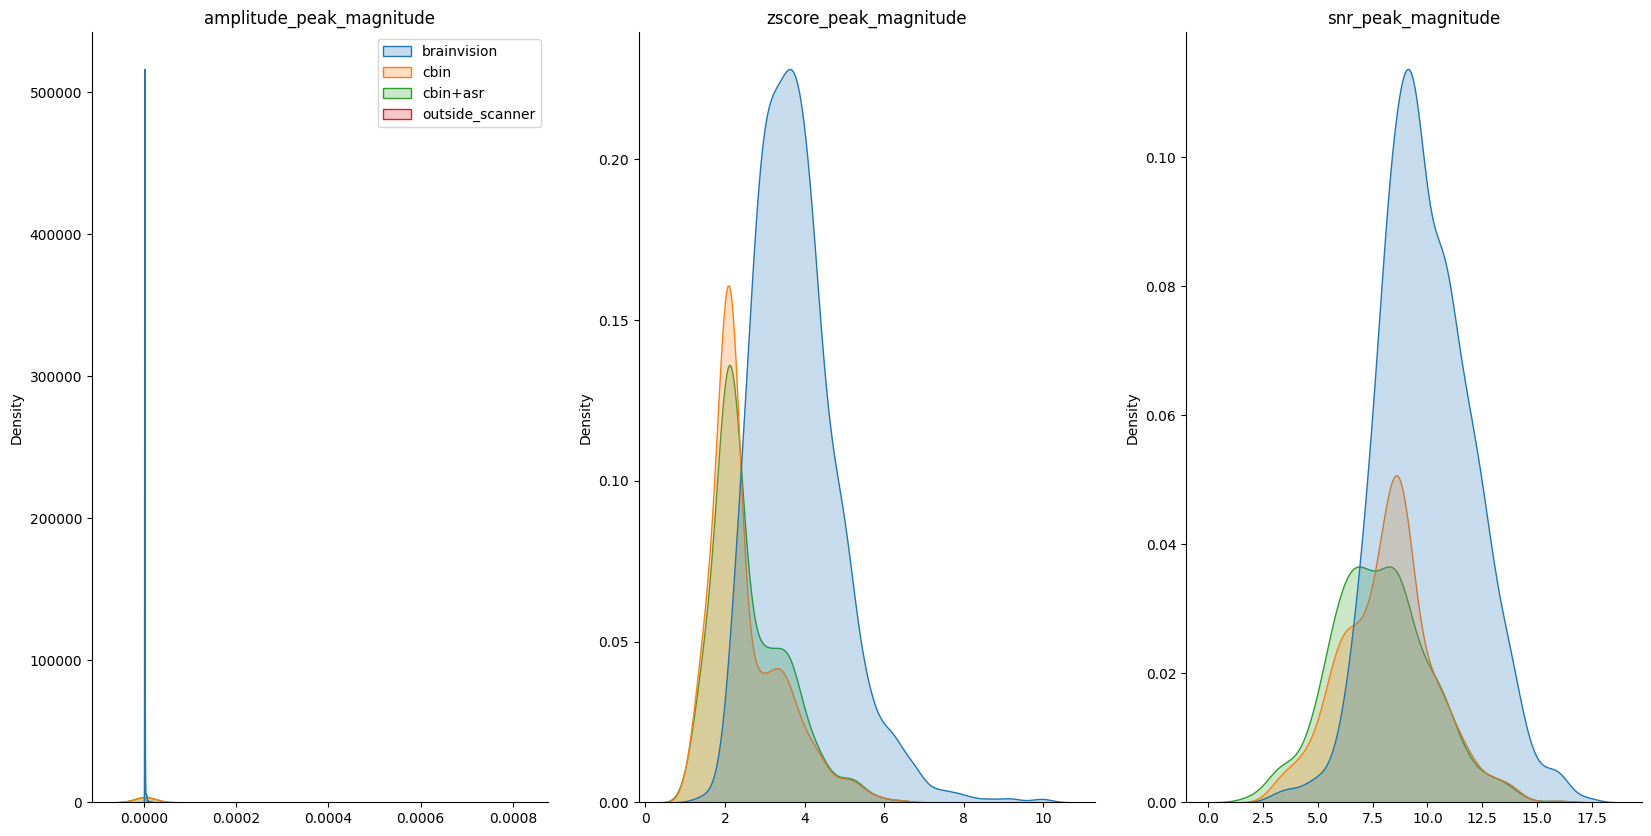

In [52]:

def plot_time_metrics(brainvision_metrics_dict,
                      sam_metrics_dict,
                      sam_asr_metrics_dict,
                      eeglab_metrics_dict,
                      #raw_metrics_dict,
                      ):
    metrics = [
        'amplitude_peak_magnitude',
        'zscore_peak_magnitude',
        'snr_peak_magnitude'
    ]

    fig, ax1 = plt.subplots(figsize = (20,10))
    ax1.spines[['right','left', 'top', 'bottom']].set_visible(False)
    ax1.set_yticks([])
    ax1.set_xticks([])

    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(1, 3, 1 + i)
        if i == 0:
            legend = True
        else:
            legend = False
        seaborn.kdeplot(data={'brainvision':brainvision_metrics_dict[metric],
                            'cbin':sam_metrics_dict[metric],
                            'cbin+asr':sam_asr_metrics_dict[metric],
                            'outside_scanner':raw_metrics_dict[metric],
                            },
                        x=None, 
                        y=None, 
                        hue=None, 
                        weights=None, 
                        palette=None, 
                        hue_order=None, 
                        hue_norm=None, 
                        color=None, 
                        fill=True, 
                        multiple='layer', 
                        common_norm=True, 
                        common_grid=False, 
                        cumulative=False, 
                        bw_method='scott', 
                        bw_adjust=1, 
                        warn_singular=True, 
                        log_scale=None, 
                        levels=10, 
                        thresh=0.05, 
                        gridsize=200, 
                        cut=3, 
                        clip=None, 
                        legend=legend, 
                        cbar=False, 
                        cbar_ax=None, 
                        cbar_kws=None, 
                        ax=ax)
        ax.spines[['top','right']].set_visible(False)
        plt.title(metric)
        #plt.xlim(xlimits[metric])
plot_time_metrics(brainvision_metrics_dict,
                  sam_metrics_dict,
                  sam_asr_metrics_dict,
                  eeglab_metrics_dict
                  #raw_metrics_dict,
                  )

# Time domaine metrics

- average_rms
- max_gradient
- zero_crossing_rate
- hjorth_mobility
- hjorth_complexity
- kurtosis
- skewness
- variance
- signal_range
- signal_iqr

# Frequency domain metrics
- amplitude
- snr
- zscore